In [1]:
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import os
import wfdb

from collections import Counter

## Data Pre-processing

In [2]:
# get all the record names in a list
namelist = []
namelist = namelist + list(range(100,125,1)) + list(range(200,235,1))
for num in [110,120,204,206,211,216,218,224,225,226,227,229]:
    namelist.remove(num)

len(namelist)

48

In [5]:
def get_window (signals, annotation):
    """
    this function gives a 0.8-seconds window (0.4-seconds before, 0.4-seconds after the annotation mark)
    of the ECG signals and assign value 1 if it's PVC beat and 0 otherwise.
    parameter: signals: numpy array containing heart beat record values
               annotation: wfdb.annotation object containing heart beat annotations
               sec: positive integer number indicating the half-width of the window
    return: two lists
            siglist: a list of lists of length 360*0.8=288 
            annlist: a list containing 1 if PVC beat, 0 otherwise
    """
    siglist = []
    annlist = []
    
    #loop through the annotation.symbol list
    for i in range(len(annotation.symbol)):
        timestamp = annotation.sample[i] #get the timestamp
        
        #test if that timestamp can have sec seconds before and after window
        windowStart = timestamp - 144
        windowEnd = timestamp + 144
        if windowStart >= 0 & windowEnd <= len(signals):
            if annotation.symbol[i] == 'V':
                # check if the length of this strip is 288
                if len(signals[windowStart:windowEnd,].flatten().tolist()) == 288:
                    siglist.append(signals[windowStart:windowEnd,].flatten().tolist())
                    annlist.append(1)
                else:
                    continue
            else:
                # check if the length of this strip is 288
                if len(signals[windowStart:windowEnd,].flatten().tolist()) == 288:
                    siglist.append(signals[windowStart:windowEnd,].flatten().tolist())
                    annlist.append(0)
        else:
            continue
    
    return siglist, annlist

In [6]:
# loop through all record to get all the 0.8-seconds window signal list and annotation list
# this could be the training dataset for the neural network model
# this takes several minutes to run

ECG_signals = []
PVC_annotations = []

for record in namelist:
    signals, fields = wfdb.rdsamp(str(record), sampfrom=0, sampto='end', channels=[1], pb_dir='mitdb')
    annotation = wfdb.rdann(str(record), 'atr', sampfrom=0, sampto=None, shift_samps=True, pb_dir='mitdb')
    
    signal_list, annotation_list = get_window(signals, annotation)
    
    ECG_signals = ECG_signals + signal_list
    PVC_annotations = PVC_annotations + annotation_list
    
    print('record', record, 'is done.')

record 100 is done.
record 101 is done.
record 102 is done.
record 103 is done.
record 104 is done.
record 105 is done.
record 106 is done.
record 107 is done.
record 108 is done.
record 109 is done.
record 111 is done.
record 112 is done.
record 113 is done.
record 114 is done.
record 115 is done.
record 116 is done.
record 117 is done.
record 118 is done.
record 119 is done.
record 121 is done.
record 122 is done.
record 123 is done.
record 124 is done.
record 200 is done.
record 201 is done.
record 202 is done.
record 203 is done.
record 205 is done.
record 207 is done.
record 208 is done.
record 209 is done.
record 210 is done.
record 212 is done.
record 213 is done.
record 214 is done.
record 215 is done.
record 217 is done.
record 219 is done.
record 220 is done.
record 221 is done.
record 222 is done.
record 223 is done.
record 228 is done.
record 230 is done.
record 231 is done.
record 232 is done.
record 233 is done.
record 234 is done.


In [7]:
# there are 112,552 such 0.8-seconds ECG signal strips
len(ECG_signals)

112552

In [8]:
# corresponding 112,552 annotations
len(PVC_annotations)

112552

In [9]:
# each 0.8-seconds ECG signal strip has 288 ECG signal values (in mV)
len(ECG_signals[0])

288

In [32]:
# there are 7129 PVC 0.8-seconds window, 105,423 non-PVC 0.8-seconds window
Counter(PVC_annotations)

Counter({0: 105423, 1: 7129})

## plot non-PVC beat and PVC beat

In [20]:
# get PVC beats index
pvc_index = []
for i in range(len(PVC_annotations)):
    if PVC_annotations[i] == 1:
        pvc_index.append(i)
pvc_index[:10]

[1905, 4258, 4847, 5856, 6044, 8736, 9643, 10751, 10760, 10778]

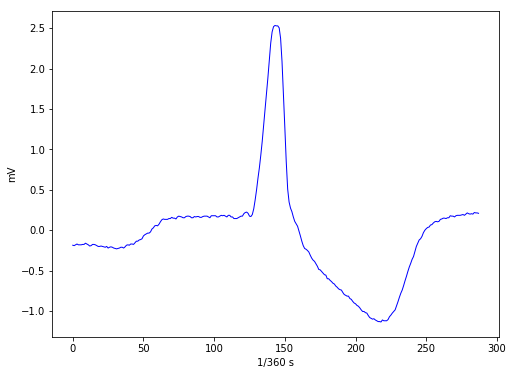

In [25]:
# plot some PVC beats
plt.figure(figsize=(8,6))
plt.plot(ECG_signals[4258], 'b-', linewidth=1)
plt.xlabel('1/360 s')
plt.ylabel('mV')
plt.show()

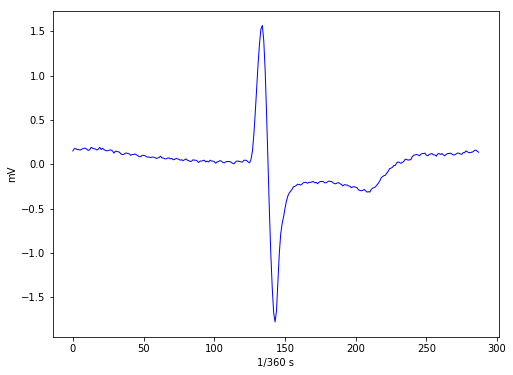

In [29]:
# plot some normal beats
plt.figure(figsize=(8,6))
plt.plot(ECG_signals[4300], 'b-', linewidth=1)
plt.xlabel('1/360 s')
plt.ylabel('mV')
plt.show()

## write the data into csv file

In [30]:
# write ECG signals data to csv file

import csv

with open('MIT-BIH-08sec-signal.csv', 'w') as f:
    f_csv = csv.writer(f)
    f_csv.writerows(ECG_signals)

In [31]:
# write the PVC annotation data to csv file

with open('MIT-BIH-08sec-annotation.csv', 'w') as f:
    f_csv = csv.writer(f)
    f_csv.writerow(PVC_annotations)

## prepare small dataset

In [33]:
# get the index in PVC_annotations for normal beats

normal_index = [i for i in range(len(PVC_annotations)) if PVC_annotations[i]==0]
len(normal_index)

105423

In [34]:
# get the index in PVC_annotations for PVC beats

PVC_index = [i for i in range(len(PVC_annotations)) if PVC_annotations[i]==1]
len(PVC_index)

7129

In [35]:
# randomly select 7129 normal beats

import random

random.seed(77)
small_normal_index = random.sample(normal_index, 7129)

In [36]:
len(small_normal_index)

7129

In [37]:
small_normal_index[:10]

[111869, 33933, 44013, 26545, 32247, 25996, 15650, 39312, 66422, 77499]

In [38]:
# concatenate 7129 normal beats index with 7129 PVC beats index
# as small data index

small_data_index = small_normal_index + PVC_index
len(small_data_index)

14258

In [39]:
# generate samll dataset

small_signals = []
for i in small_data_index:
    small_signals.append(ECG_signals[i])
    
small_annotations = []
for i in small_data_index:
    small_annotations.append(PVC_annotations[i])

In [40]:
len(small_signals)

14258

In [41]:
len(small_annotations)

14258

In [42]:
# write ECG signals data to csv file

import csv

with open('MIT-BIH-08sec-small-signal.csv', 'w') as f:
    f_csv = csv.writer(f)
    f_csv.writerows(small_signals)

In [43]:
# write the PVC annotation data to csv file

with open('MIT-BIH-08sec-small-annotation.csv', 'w') as f:
    f_csv = csv.writer(f)
    f_csv.writerow(small_annotations)

## Classification Models

In [44]:
# transform data into numpy array

X = np.array(small_signals)
y = np.array(small_annotations)

In [45]:
X.shape

(14258, 288)

In [46]:
y.shape

(14258,)

In [47]:
# split train and test set

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

In [48]:
X_train.shape

(9980, 288)

In [49]:
y_train.shape

(9980,)

In [50]:
X_test.shape

(4278, 288)

In [51]:
y_test.shape

(4278,)

In [52]:
# the ratio of PVC beats in training set and test set

Counter(y_train)

Counter({0: 4984, 1: 4996})

In [53]:
Counter(y_test)

Counter({0: 2145, 1: 2133})

In [54]:
# baseline model accuracy

2145/(2145+2133)

0.5014025245441796

### Logistic Regression Model

In [55]:
from sklearn.linear_model import LogisticRegression

In [56]:
from sklearn.metrics import confusion_matrix

In [57]:
# logistic regression model

log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [58]:
# predict

y_train_pred = log_reg.predict(X_train)

In [59]:
# confusion matrix

confusion_matrix(y_train, y_train_pred)

array([[3767, 1217],
       [1363, 3633]], dtype=int64)

In [60]:
# accuracy

(3767+3633)/(3767+1217+1363+3633)

0.7414829659318637

In [61]:
# True Positive Rate

3633/(1363+3633)

0.7271817453963171

In [62]:
# False Positive Rate

1217/(3767+1217)

0.24418138041733548

In [63]:
# testing result

y_test_pred = log_reg.predict(X_test)
confusion_matrix(y_test, y_test_pred)

array([[1606,  539],
       [ 567, 1566]], dtype=int64)

In [64]:
# accuracy

(1606+1566)/(1606+539+567+1566)

0.7414679756895746

In [65]:
# True Positive Rate

1566/(567+1566)

0.7341772151898734

In [66]:
# False Positive Rate

539/(1606+539)

0.2512820512820513

In [67]:
# save the model

import pickle

# Dump the trained logistic regression model with Pickle
LogReg_pkl_filename = 'LogRegSmall.pkl'

# Open the file to save as pkl file
LogReg_model_pkl = open(LogReg_pkl_filename, 'wb')
pickle.dump(log_reg, LogReg_model_pkl)

# Close the pickle instances
LogReg_model_pkl.close()

### Random Forest Model

In [68]:
from sklearn.ensemble import RandomForestRegressor

In [69]:
# random forest model

forest_reg = RandomForestRegressor()
forest_reg.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [70]:
# training set result

y_train_pred = forest_reg.predict(X_train)
y_train_pred = [int(x) for x in y_train_pred]
confusion_matrix(y_train, y_train_pred)

array([[4984,    0],
       [1188, 3808]], dtype=int64)

In [71]:
# accuracy

(4984+3808)/(4984+0+1188+3808)

0.8809619238476953

In [72]:
# True Positive Rate

3808/(1188+3808)

0.7622097678142514

In [73]:
# False Positive Rate

0

0

In [74]:
# testing set result

y_test_pred = forest_reg.predict(X_test)
y_test_pred = [int(x) for x in y_test_pred]
confusion_matrix(y_test, y_test_pred)

array([[2125,   20],
       [ 764, 1369]], dtype=int64)

In [75]:
# accuracy

(2125+1369)/(2125+20+764+1369)

0.8167367928938757

In [76]:
# True Positive Rate

1369/(764+1369)

0.6418190342240975

In [77]:
# False Positive Rate

20/(2125+20)

0.009324009324009324

In [78]:
# save the model

import pickle

# Dump the trained random forest classifier with Pickle
RandomForest_pkl_filename = 'RandomForestSmall.pkl'

# Open the file to save as pkl file
RandomForest_model_pkl = open(RandomForest_pkl_filename, 'wb')
pickle.dump(forest_reg, RandomForest_model_pkl)

# Close the pickle instances
RandomForest_model_pkl.close()

### Neural Network Model

In [79]:
import tensorflow as tf

C:\Users\movin\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [80]:
n_inputs = 288
n_hidden1 = 100
n_hidden2 = 30
n_outputs = 2

In [81]:
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name='X')
y = tf.placeholder(tf.int64, shape=(None), name='y')

In [82]:
# construct neural network

with tf.name_scope('dnn'):
    hidden1 = tf.layers.dense(X, n_hidden1, name='hidden1', activation=tf.nn.relu)
    hidden2 = tf.layers.dense(hidden1, n_hidden2, name='hidden2', activation=tf.nn.relu)
    logits = tf.layers.dense(hidden2, n_outputs, name='outputs')

In [83]:
# define cost function

with tf.name_scope('loss'):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name='loss')

In [84]:
# define optimizer

learning_rate = 0.01

with tf.name_scope('train'):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [85]:
# define evaluation

with tf.name_scope('eval'):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [86]:
# create init and saver

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [87]:
# execution

n_epochs = 30
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(len(X_train)//batch_size):
            batch_index = random.sample(range(len(X_train)), batch_size)
            X_batch = X_train[batch_index]
            y_batch = y_train[batch_index]
            sess.run(training_op, feed_dict={X:X_batch, y:y_batch})
        acc_train = accuracy.eval(feed_dict={X:X_batch, y:y_batch})
        acc_test = accuracy.eval(feed_dict={X:X_test, y:y_test})
        print(epoch, 'Train accuracy:', acc_train, 'Test accuracy:', acc_test)
        
    save_path = saver.save(sess, './dnn_model.ckpt')

0 Train accuracy: 0.84 Test accuracy: 0.80014026
1 Train accuracy: 0.84 Test accuracy: 0.8347359
2 Train accuracy: 0.88 Test accuracy: 0.84455353
3 Train accuracy: 0.88 Test accuracy: 0.8517999
4 Train accuracy: 0.92 Test accuracy: 0.8553062
5 Train accuracy: 0.86 Test accuracy: 0.8775129
6 Train accuracy: 0.9 Test accuracy: 0.87237024
7 Train accuracy: 0.94 Test accuracy: 0.88616174
8 Train accuracy: 0.94 Test accuracy: 0.88475925
9 Train accuracy: 0.96 Test accuracy: 0.886863
10 Train accuracy: 0.94 Test accuracy: 0.8962132
11 Train accuracy: 0.94 Test accuracy: 0.89410937
12 Train accuracy: 0.92 Test accuracy: 0.89948577
13 Train accuracy: 0.86 Test accuracy: 0.9062646
14 Train accuracy: 0.88 Test accuracy: 0.9057971
15 Train accuracy: 0.94 Test accuracy: 0.90906966
16 Train accuracy: 0.94 Test accuracy: 0.9062646
17 Train accuracy: 0.94 Test accuracy: 0.9118747
18 Train accuracy: 0.9 Test accuracy: 0.9130435
19 Train accuracy: 0.9 Test accuracy: 0.914446
20 Train accuracy: 0.98 Tes

In [88]:
with tf.Session() as sess:
    saver.restore(sess, './dnn_model.ckpt')
    Z = logits.eval(feed_dict={X:X_test})
    y_pred = np.argmax(Z, axis=1)

INFO:tensorflow:Restoring parameters from ./dnn_model.ckpt


In [89]:
confusion_matrix(y_test, y_pred)

array([[2055,   90],
       [ 182, 1951]], dtype=int64)

In [90]:
# accuracy

(2055+1951)/(2055+90+182+1951)

0.9364188873305282

In [91]:
# True Positive Rate

1951/(182+1951)

0.9146741678387248

In [92]:
# False Positive Rate

90/(2055+90)

0.04195804195804196

## Compare Results

|model|accuracy|true positive rate|false positive rate|
|-----|--------|------------------|-------------------|
|baseline|0.5014|0.0|0.0|
|Logistic Regression training|0.7415|0.7272|0.2442|
|Logistic Regression testing|0.7415|0.7342|0.2513|
|Random Forest training|0.8810|0.7622|0.0|
|Random Forest testing|0.8167|0.6418|0.0093|
|Neural Network training|1.0|1.0|0.0|
|Neural Network testing|0.9364|0.9147|0.0420|